# Hopfield networks

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import itertools

## Hopfield Network class

In [2]:
class HopfieldNetwork():
    """ Class for Hopfield Network.
    
    Attributes
    ----------
    units : int
        The number of neurons in the network.
    weights : numpy.ndarray
        Weight matrix of shape (units, units).
    sparse : bool
        If patterns are sparse, then a modified update rule is used in recall.
        
    Methods
    -------
    init_weights(patterns, self_connections=False, norm=False)
        Initalizes the weights of the network.
    recall(pattern)
        Recall a pattern, i.e.: a single data vector.
    recall_until_convergence(pattern, exit=100)
        Recall a single pattern until it converges. If does not converge, 
        exit after exit numbers of iterations.
    get_attractors(verbose=False)
        Return a 2D array of the attractors where each attractor is a row in the
        array. The array is of shape (n_attractors, units).
    if_attractor(attractor)
        Check if the pattern called attractor is an attractor of the energy landscape
        of the network.

    """
    def __init__(self, sparse=False):
        self.units = None
        self.weights = None
        self.sparse = sparse
    
    def init_weights(self, patterns, self_connections=False, norm=False, bias=0):
        """ Initalizes the weights of the network.
        
        Parameters
        ----------
        patterns : numpy.ndarray
            Patterns of shape (n_patterns, n_features). n_features is equal to self.units.
        self_connections : bool
            Whether to allow the self-connections of neurons.
        norm : bool
            Whether to normalize the weight matrix. Important when bias is used.
        bias : float
            Bias term in sparse pattern update rule.

        Returns
        -------
        None
        
        """
        self.units = patterns.shape[1]
        self.weights = np.zeros((patterns.shape[1], patterns.shape[1]))
        
        average_activity = np.sum(patterns) * (self.units * patterns.shape[0])**(-1)
        
        for idx, pattern in enumerate(patterns):
            if self.sparse:
                vec = pattern - average_activity
                self.bias = bias
            else:
                vec = pattern.copy()
            
            self.weights += np.outer(vec, vec)
        
        if not self_connections:
            np.fill_diagonal(self.weights, 0)
        
        if norm:
            self.weights /= self.units
        
        assert np.all(np.abs(self.weights - self.weights.T) < 10e-8), "non-symmetric weight matrix"
        
    def set_weights(self, **rule_dict):
        """ Set the weights of the network.
        
        Parameters
        ----------
        rule_dict : dict
            The rule of setting the weights. Could be gaussian (then has loc and scale), or
            symmetrize.

        Returns
        -------
        None
        
        """
        if rule_dict["rule"] == "gaussian":
            self.weights = np.random.normal(loc=rule_dict["loc"], scale=rule_dict["scale"], 
                                            size=(self.units, self.units))
        elif rule_dict["rule"] == "symmetrize":
            self.weights = 0.5 * (self.weights + self.weights.T)
            assert np.all(self.weights == self.weights.T), "not symmetric weight matrix"
            
        else:
            raise Exception(f"Incorrect rule in {rule_dict}")
        
    def recall(self, pattern, if_sequential):
        """ Recall a pattern, i.e.: a single data vector.
        
        Parameters
        ----------
        pattern : numpy.ndarray
            Pattern of shape (self.units, 1)
        
        if_sequential : bool
            Do sequential instead of batch update to recall.
    
        Returns
        -------
        pattern : numpy.ndarray
            Recalled pattern of shape (self.units, 1)
        
        """
        if self.sparse:
            if not if_sequential:
                pattern = np.dot(self.weights, pattern) - self.bias
            else:
                raise NotImplementedError
            
            mask = pattern < 0
            pattern[mask] = -1.0
            pattern[np.invert(mask)] = 1.0
            
            pattern = 0.5 + 0.5*pattern
            
        else:
            if not if_sequential:
                pattern = np.dot(self.weights, pattern)
            else:
                idx = np.random.randint(pattern.shape[0])
                pattern[idx] = float(np.dot(self.weights[idx,:].reshape(1,-1), pattern))

            mask = pattern < 0
            pattern[mask] = -1.0
            pattern[np.invert(mask)] = 1.0
            
        return pattern
    
    def recall_until_convergence(self, pattern, if_sequential, with_energy, exit=100, **viz_recall_dict):
        """ Recall a single pattern until it converges. If does not converge, 
        exit after exit numbers of iterations.
        
        Parameters
        ----------
        pattern : numpy.ndarray
            Pattern of shape (self.units, 1)
        
        if_sequential : bool
            Do sequential instead of batch update to recall.
        
        with_energy : bool
            Return the energy of the recalls after each iteration as list for plotting.
        
        exit : int
            Exit loop after this many iterations (means that within exit number
            of iterations the pattern did not converge to any attractors).
            If if_sequential is False (i.e.: batch update), then exit loop either at
            convergence or after exit number of iterations.
            If if_sequential is True, force the loop to go up to exit number of iterations.
            (This is a temproaray solution the problem is that when selecting an element in
            pattern at random, the recall could look exactly like in the previous itertaion, and 
            so convergence woul be reached, which actually would not be the case. So just
            force the loop until exit no. of iterations when if_sequential is True)
            
        viz_recall_dict : dict
            Rules for visualizing recall per iteration.
    
        Returns
        -------
        patternr : numpy.ndarray
            Recalled pattern of shape (self.units, 1)
        
        i : int
            Convergence after i iterations.
        
        energies : list
            List of energy values per iteration.
        
        """
        patternr_prev = np.zeros(pattern.shape)
        patternr = pattern.copy()
        i = 0
        exit_condition = False
        energies = []
        
        while not exit_condition:
            patternr_prev = patternr.copy()
            patternr = self.recall(patternr_prev, if_sequential)
            
            i += 1
            
            if with_energy:
                energies.append(self.energy(patternr))
            
            if viz_recall_dict:
                if i % viz_recall_dict["i"] == 0:
                    self.viz_recall(patternr, i, shape=viz_recall_dict["shape"])
            
            if not if_sequential:
                exit_condition = np.all(patternr == patternr_prev)
            else:
                # if not sequential, do until exit iterations pass (temporary solution)
                exit_condition = False
            
            if i == exit:
                #patternr = None
                break
                
        return patternr, i, energies
    
    def viz_recall(self, pattern, i, shape):
        """ Recall a pattern, i.e.: a single data vector.
        
        Parameters
        ----------
        pattern : numpy.ndarray
            Pattern of shape (self.units, 1)
        
        i : int
            Iteration number
        
        shape : tuple
            Shape of recall to be visualized, e.g.: (32,32) for the pict data. 
    
        Returns
        -------
        None
        
        """
        plt.imshow(pattern.reshape(shape).T)
        plt.axis("off")
        plt.title(f"Recall at iteration {i}")
        plt.show()
    
    def get_attractors(self, if_sequential, verbose=False):
        """ Return a 2D array of the attractors where each attractor is a row in the
        array. The array is of shape (n_attractors, units).
        
        Parameters
        ----------
        if_sequential : bool
            Do sequential instead of batch update to recall.
            
        verbose : bool
            Whether to print info about which pattern (of all possible patterns)
            is being processed (recalled until convergence).
        
        Returns
        -------
        unique_attractors : numpy.ndarray
            The array of all attractors of the network's energy landscape.
            Of shape (n_attractors, units).
        """
        with_energy = False
        patterns_all = np.array(list(itertools.product([-1, 1], repeat=self.units))).astype(float)
        attractors = []
        
        for pattern in patterns_all:
            if verbose:
                print(f"processing {idx+1}/{patterns_all.shape[0]}")
            patternr, _, _ = self.recall_until_convergence(pattern, with_energy, if_sequential, exit=100)
            attractors.append(patternr)
           
        attractors = np.array(attractors)
        unique_attractors = np.unique(attractors, axis=0)
        
        return unique_attractors
    
    def if_attractor(self, attractor, if_sequential):
        """ Check if the pattern called attractor is an attractor of the energy landscape
        of the network.
        
        Parameters
        ----------
        attractor : numpy.ndarray
            Whether to print info about which pattern (of all possible patterns)
            is being processed (recalled until convergence). Of shape (self.units,).
        
        if_sequential : bool
            Do sequential instead of batch update to recall.
        
        Returns
        -------
        idx : int or None
            If the pattern is an attractor of the network, then return its index in
            the attractor array (generated by self.get_attractors(verbose=False)).
            If not attractor, return None.
        """
        assert attractor.ndim == 1, "attractor should be 1d instead of 2d"
        unique_attractors = self.get_attractors(if_sequential)
        
        for idx, unique_attractor in enumerate(unique_attractors):
            if np.all(unique_attractor == attractor):
                return idx

        return None
  
    def energy(self, pattern):
        """ Compute energy of pattern in the energy landscape defined by the weights.
        
        Parameters
        ----------
        pattern : numpy.ndarray
            Pattern of shape (self.units, ), NEEDS to be 1D
        
        Returns
        -------
        float
            Energy.
        """
        assert pattern.ndim == 1, "pattern needs to be 1D, got 2D"
        return - np.linalg.multi_dot([pattern, self.weights, pattern])

## Testing content addresable memory

If the network has succeeded in storing the patterns x1, x2, and x3, they should all be fixed points upon applying the update rule (i.e: applying the update rule to these patterns you retrieves the same pattern back (content addresable memory).

weights are
[[ 3.  1. -1.  3.  1. -1.  3. -1.]
 [ 1.  3.  1.  1. -1.  1.  1.  1.]
 [-1.  1.  3. -1.  1. -1. -1.  3.]
 [ 3.  1. -1.  3.  1. -1.  3. -1.]
 [ 1. -1.  1.  1.  3. -3.  1.  1.]
 [-1.  1. -1. -1. -3.  3. -1. -1.]
 [ 3.  1. -1.  3.  1. -1.  3. -1.]
 [-1.  1.  3. -1.  1. -1. -1.  3.]]
Recalling x1


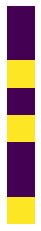

get


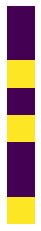

In [3]:
# Random patterns for testing content addresable memory
x1 = np.array([-1, -1, 1, -1, 1, -1, -1, 1]).reshape(-1,1)
x2 = np.array([-1, -1, -1, -1, -1, 1, -1, -1]).reshape(-1,1)
x3 = np.array([-1, 1, 1, -1, -1, 1, -1, 1]).reshape(-1,1)

patterns = np.vstack([x1.T, x2.T, x3.T])


hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True)

print("weights are")
print(hn.weights)

rx1 = hn.recall(x1, if_sequential=False)
rx2 = hn.recall(x2, if_sequential=False)
rx3 = hn.recall(x3, if_sequential=False)

assert np.all(x1 == rx1), "x1 cannot be addressed"
assert np.all(x2 == rx2), "x2 cannot be addressed"
assert np.all(x3 == rx3), "x3 cannot be addressed"

print("Recalling x1")
plt.imshow(rx1)
plt.axis("off")
plt.show()

print("get")
plt.imshow(x1)
plt.axis("off")
plt.show()

All can be retrieved, content addressable memory works. x1, x2, and x3 will be attractors of the network.

## Convergence and attractors

Recalling distorted patterns. x1d has a one bit error, x2d and x3d have two bit errors.

xd1 converged to x1 after 2 iterations
xd1


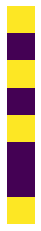

converged to


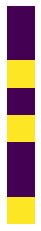

it should have converged to x1


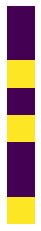

xd2 did not converge to x2
xd2


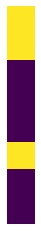

converged to


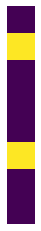

it should have converged to x2


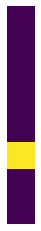

xd3 converged to x3 after 3 iterations
xd3


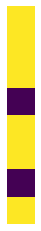

converged to


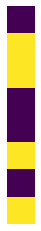

it should have converged to x3


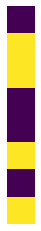

In [4]:
x1d = np.array([1, -1, 1, -1, 1, -1, -1, 1]).reshape(-1,1)
x2d = np.array([1, 1, -1, -1, -1, 1, -1, -1]).reshape(-1,1)
x3d = np.array([1, 1, 1, -1, 1, 1, -1, 1]).reshape(-1,1)

patternsd = np.vstack([x1d.T, x2d.T, x3d.T])

hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True)

for idx, p, pd in zip(range(patterns.shape[0]), patterns, patternsd):
    pr, it, _ = hn.recall_until_convergence(pd, with_energy=False, if_sequential=False)
    if np.all(pr == p):
        print(f"xd{idx+1} converged to x{idx+1} after {it} iterations")
    else:
        print(f"xd{idx+1} did not converge to x{idx+1}")
    
    print(f"xd{idx+1}")
    plt.imshow(pd.reshape(-1,1))
    plt.axis("off")
    plt.show()
    
    print(f"converged to")
    plt.imshow(pr.reshape(-1,1))
    plt.axis("off")
    plt.show()
    
    
    print(f"it should have converged to x{idx+1}")
    plt.imshow(p.reshape(-1,1))
    plt.axis("off")
    plt.show()

With self_connections = False, only x1d converges to x1 in 2 iterations, the rest do not converge at all.
With self_connections = True, all converge - x1d to x1 in 2 iterations, x2d to a 1-bit corrupted (at index 1) version of x2, and x3d to x3 in 3 iterations.

Finding the number of attractors in the network.

In [5]:
attractors = hn.get_attractors(if_sequential=False)
print(attractors)
print(f"There are {attractors.shape[0]} attractors (each one is a row)")

for idx, pattern in enumerate(patterns):
    idx_attractor = hn.if_attractor(pattern, if_sequential=False)
    print(f"x{idx+1} is an attractor at index {idx_attractor}")

[[-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]]
There are 14 attractors (each one is a row)
x1 is an attractor at index 3
x2 is an attractor at index 0
x3 is an attractor at index 6


When the starting pattern is made even more dissimilar to the stored ones (e.g. more than half is wrong), the distorted patterns do not converge to their correct attractor.

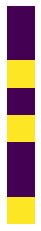

In [6]:
patterns_for_x1 = np.array([[-1, 1, -1, 1, -1, -1, -1, 1], # last 3 same as x1
                            [1, -1, 1, 1, -1, 1, 1, -1],# first 3 same
                            [1, 1, -1, 1, -1, 1, 1, -1]]) # only 1st same

plt.imshow(x1)
plt.axis("off")
plt.show()

all should converge to x1


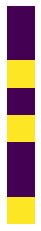

converged to x1: False


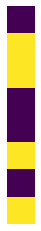

converged to x1: False


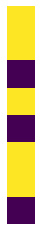

converged to x1: False


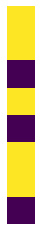

In [7]:
print("all should converge to x1")
plt.imshow(x1.reshape(-1,1))
plt.axis("off")
plt.show()

for pattern_for_x1 in patterns_for_x1:
    x1r, it, _ = hn.recall_until_convergence(pattern_for_x1, with_energy=False, if_sequential=False)
    print(f"converged to x1: {np.all(pattern_for_x1 == x1)}")
    plt.imshow(x1r.reshape(-1,1))
    plt.axis("off")
    plt.show()

## Sequential / Asynchronous Update

In [8]:
def read_pict_data(path_2_data):
    """ Read pict.dat data. 11 binary images of shape (32, 32). Last two are distorted 
    versions of previous ones.
    
    Parameters
    ----------
    path_2_data : str
        Path to data.
    
    Returns
    ----------
    numpy.ndarray
        Data as array of shape (11, 1024)
    """
    ndim = 1024
    return np.loadtxt(path_2_data, delimiter=",", dtype=int).reshape(-1, ndim)
    
path_2_data='pict.dat'
patterns_all = read_pict_data(path_2_data)

# Get first 3 images.
patterns = patterns_all[:3,:]
print(patterns.shape)

(3, 1024)


Check an example image.

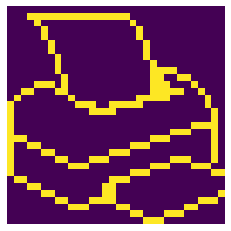

In [9]:
show_idx = 0
plt.imshow(patterns[show_idx].reshape(32,-1).T)
plt.axis("off")
plt.show()

Add teh first 3 images to the network and test if they are stable with synchronous update.

in 1 iterations this converged to


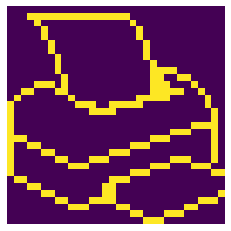

this


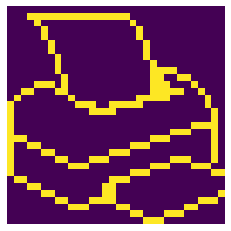

in 1 iterations this converged to


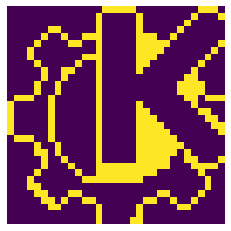

this


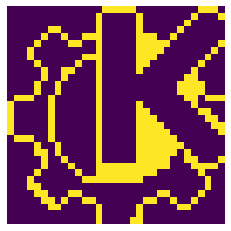

in 1 iterations this converged to


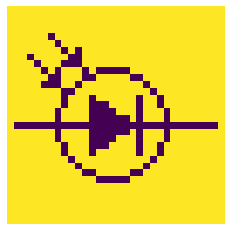

this


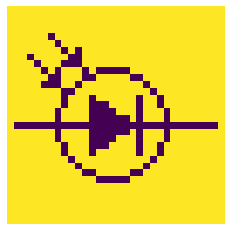

In [10]:
hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=False, norm=False)

for pattern in patterns:
    patternr, it, _ = hn.recall_until_convergence(pattern, with_energy=False, if_sequential=False, exit=100)
    print(f"in {it} iterations this converged to")
    plt.imshow(pattern.reshape(32,-1).T)
    plt.axis("off")
    plt.show()
    print(f"this")
    plt.imshow(patternr.reshape(32,-1).T)
    plt.axis("off")
    plt.show()

Image at index 9 is the distorted version of image at index 0.

p10 below


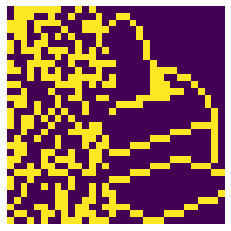

is a degraded version of p1 below


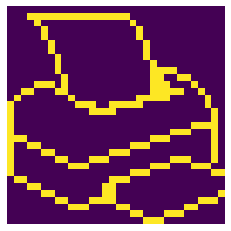

In [11]:
print("p10 below")
plt.imshow(patterns_all[9].reshape(32,-1).T)
plt.axis("off")
plt.show()

print("is a degraded version of p1 below")
plt.imshow(patterns_all[0].reshape(32,-1).T)
plt.axis("off")
plt.show()

Let's try to recall it with synchronous update.

in 2 iterations p10 converged to


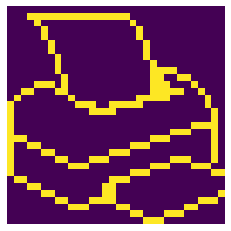

In [12]:
patternr, it, _ = hn.recall_until_convergence(patterns_all[9], 
                                              if_sequential=False, with_energy=False, exit=1000)
print(f"in {it} iterations p10 converged to")
plt.imshow(patternr.reshape(32,-1).T)
plt.axis("off")
plt.show()

p10 converges to stable point p1 in 2 iterations.

image at index 10 is a mixture of the images at indices 1 and 2

p11 below


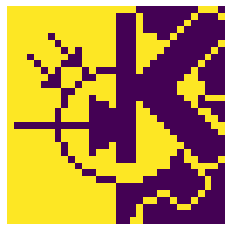

is a mixture of version of p2 and p3 below (in this order)


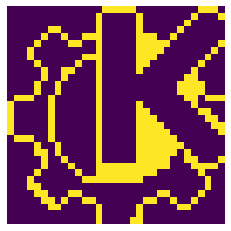

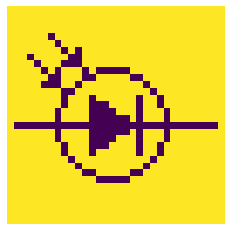

In [13]:
print("p11 below")
plt.imshow(patterns_all[10].reshape(32,-1).T)
plt.axis("off")
plt.show()

print("is a mixture of version of p2 and p3 below (in this order)")
plt.imshow(patterns_all[1].reshape(32,-1).T)
plt.axis("off")
plt.show()

plt.imshow(patterns_all[2].reshape(32,-1).T)
plt.axis("off")
plt.show()

Let's try to recall it with synchronous update.

in 3 iterations p11 converged to


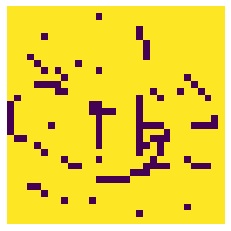

In [14]:
viz_recall_dict = {}
patternr, it, _ = hn.recall_until_convergence(patterns_all[10], if_sequential=False, with_energy=False,
                                           exit=10000, **viz_recall_dict)
print(f"in {it} iterations p11 converged to")
plt.imshow(patternr.reshape(32,-1).T)
plt.axis("off")
plt.show()

p11 converges in 2-3 iterations to a spurious stable point (neither p2 or p3)

However, p11 does converge to p3 when the asynchrnonous update rule is used.

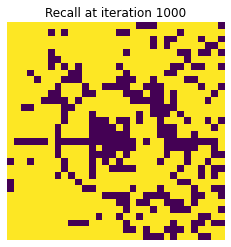

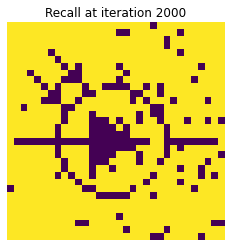

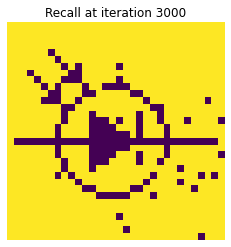

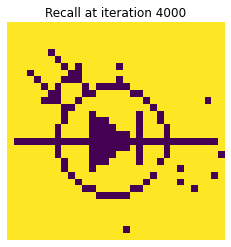

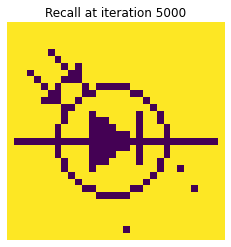

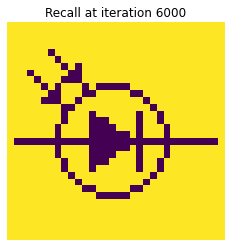

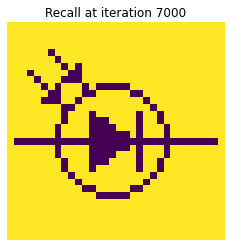

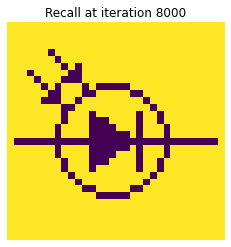

in 8000 iterations p11 converged to


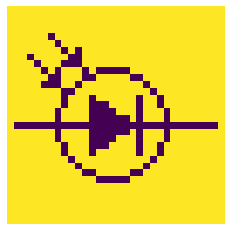

In [15]:
viz_recall_dict = {"i": 1000, "shape": (32, 32)}
patternr, it, _ = hn.recall_until_convergence(patterns_all[10], if_sequential=True, with_energy=False,
                                           exit=8000, **viz_recall_dict)
print(f"in {it} iterations p11 converged to")
plt.imshow(patternr.reshape(32,-1).T)
plt.axis("off")
plt.show()

After around 8k iterations, we p11 converges to the stable point p3 with sequential update.

## Energy in Hopfield Networks

The energies of the image data points in the network that stores the first 3 images are

In [16]:
for idx, pattern in enumerate(patterns_all):
    print(f"x{idx+1} e: {hn.energy(pattern.flatten())}")

x1 e: -1470864.0
x2 e: -1395344.0
x3 e: -1494272.0
x4 e: -734700.0
x5 e: -535440.0
x6 e: -696624.0
x7 e: -699116.0
x8 e: -172592.0
x9 e: -270860.0
x10 e: -422892.0
x11 e: -174592.0


The distorted p10 and the mixed p11 have greater energy, which it makes sense as they are not attractors - p10 is a degraded version of p1, and p11 is a mix between p2 and p3.

Asynchrnously recall p11 (mix) and observe the energy vs. iteration. The energy is minimized at the recalled pattern approaches the attractor - a local minimum in the energy landscape of the network.

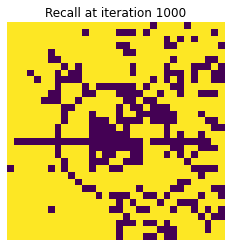

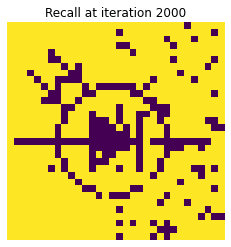

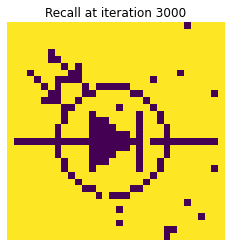

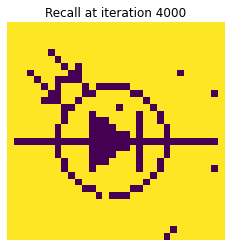

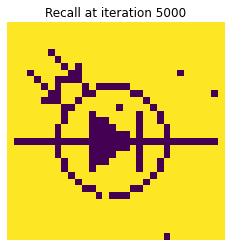

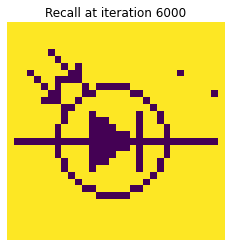

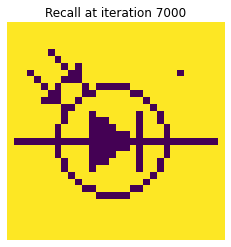

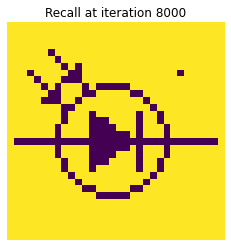

in 8000 iterations p11 converged to


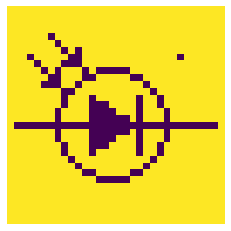

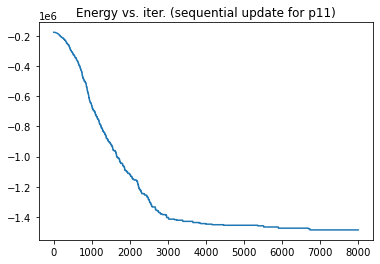

In [17]:
viz_recall_dict = {"i": 1000, "shape": (32, 32)}
patternr, it, energies = hn.recall_until_convergence(patterns_all[10], if_sequential=True, with_energy=True,
                                           exit=8000, **viz_recall_dict)
print(f"in {it} iterations p11 converged to")
plt.imshow(patternr.reshape(32,-1).T)
plt.axis("off")
plt.show()

plt.plot(energies)
plt.title("Energy vs. iter. (sequential update for p11)")
plt.show()

Setting (forcing) the weight matrix of the network to be drawn from a normal distribution (i.e.: not symmetric, should fail to recall), and iterating an arbitrary starting state (e.g.: p2) reults in the following: the recalled pattern is not drawn to any attractor, and the energy is fluctuating, even reaches postitive values - the recall is also Gaussian noise.

the weights are forced to by asymmetric Gaussian
[[-1.4980634  -0.86355605  0.53675219 ...  0.57447774  0.6408322
  -0.71132156]
 [ 0.08751037  0.08086753 -1.08115747 ... -0.85972068  1.03219596
  -1.50016862]
 [ 0.56800074  2.38406788  0.45933858 ... -0.20351043 -0.07330078
  -1.01857697]
 ...
 [ 0.66836657 -0.82942074 -1.24256111 ... -0.59896846  0.75530048
   0.25108939]
 [-0.38514932  1.03115923  0.03718502 ... -0.03980832 -0.92732335
  -1.77751229]
 [ 0.05891325  1.55241916 -0.34359252 ...  0.86810106  0.3677978
  -0.6121712 ]]


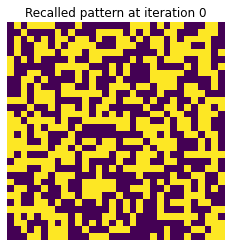

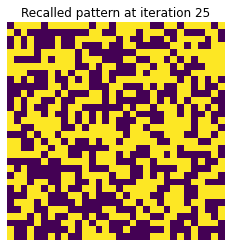

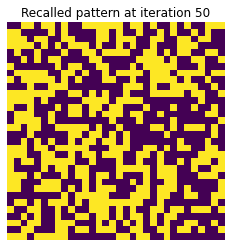

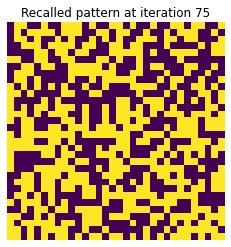

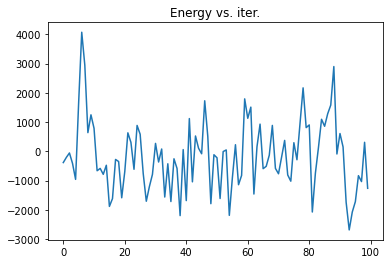

In [18]:
rule_dict = {"rule": "gaussian", "loc": 0.0, "scale": 1.0}
#rule_dict = {"rule": "symmetrize"}
hn.set_weights(**rule_dict)
assert not np.all(hn.weights == hn.weights.T)

print("the weights are forced to by asymmetric Gaussian")
print(hn.weights)

es = []
p_random = patterns_all[1]
for i in range(100):
    p_random = hn.recall(p_random, if_sequential=False)
    es.append(hn.energy(p_random.flatten()))
    if i % 25 == 0:
        plt.imshow(p_random.reshape(32,32).T)
        plt.title(f"Recalled pattern at iteration {i}")
        plt.axis("off")
        plt.show()

plt.plot(es)
plt.title("Energy vs. iter.")
plt.show()

Now, the weight matrix is forced to be symmetric (e.g. by setting w=0.5*(w+w')), but from the previous Gaussain. As a result, the weigts do not store the first 3 patterns.

Iterating a pattern (e.g.: p2), the recalled pattern is now drawn to an attractor since the weights are symmetric. But, this attractor is a spurious attractor since the weights do not store the desired 3 patterns. The energy gets stuck in local minimum (not global).

the symmetric weigths are
[[-1.4980634  -0.38802284  0.55237647 ...  0.62142215  0.12784144
  -0.32620415]
 [-0.38802284  0.08086753  0.65145521 ... -0.84457071  1.0316776
   0.02612527]
 [ 0.55237647  0.65145521  0.45933858 ... -0.72303577 -0.01805788
  -0.68108474]
 ...
 [ 0.62142215 -0.84457071 -0.72303577 ... -0.59896846  0.35774608
   0.55959523]
 [ 0.12784144  1.0316776  -0.01805788 ...  0.35774608 -0.92732335
  -0.70485724]
 [-0.32620415  0.02612527 -0.68108474 ...  0.55959523 -0.70485724
  -0.6121712 ]]


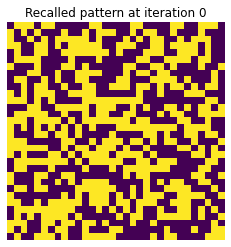

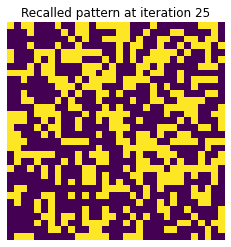

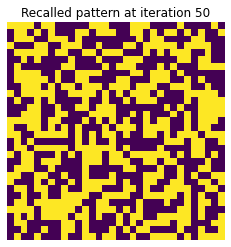

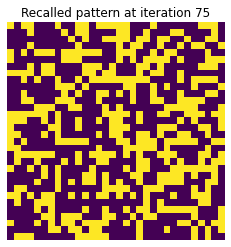

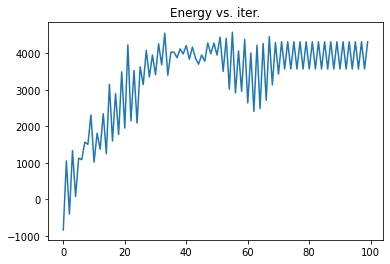

In [19]:
# Symmetrize prev Gaussian.
rule_dict = {"rule": "symmetrize"}
hn.set_weights(**rule_dict)
assert np.all(hn.weights == hn.weights.T)
print("the symmetric weigths are")
print(hn.weights)

es = []
p_random = patterns_all[1]
for i in range(100):
    p_random = hn.recall(p_random, if_sequential=False)
    es.append(hn.energy(p_random.flatten()))
    if i % 25 == 0:
        plt.imshow(p_random.reshape(32,32).T)
        plt.title(f"Recalled pattern at iteration {i}")
        plt.axis("off")
        plt.show()

plt.plot(es)
plt.title("Energy vs. iter.")
plt.show()

## 3.4 Distortion Resistance

Here, the resistance of Hopfield network to noise and distortion is investigated. To study the network's robustness, noisy / distorted test patterns by randomly fipping a selected number of units in the patterns are generated. The aim is to see if the network can recover the original clean patterns that have been used for training.

In [20]:
def add_noise_via_flip(pattern, ratio, seed=100):
    """ Adds noise to a pattern via fliping a ratio of the pixels.
    
    Parameters
    ----------
    pattern : numpy.ndarray
        Pattern vector.
    
    ratio : float
        The ratio of flips.
        
    seed : int
        Random seed.
    
    Returns
    ----------
    pattern_noisy : numpy.ndarray
        Noisy pattern.
    """
    assert pattern.ndim == 1
    assert 0 <= ratio <= 1.0
    indices = np.arange(pattern.size)
    n = int(ratio * pattern.size)
    np.random.seed(seed)
    indices_flip = np.random.choice(indices, n, replace=False)
    pattern_noisy = pattern.copy()
    pattern_noisy[indices_flip] = - pattern[indices_flip]
    return pattern_noisy

In [21]:
patterns_all = read_pict_data(path_2_data)
patterns = patterns_all[:3,:]
print(patterns.shape)

(3, 1024)


Example added noise.

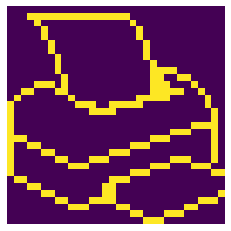

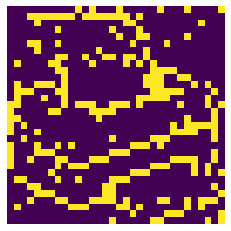

In [22]:
idx = 0
ratio = 0.1

plt.imshow(patterns[idx].reshape(32,-1).T)
plt.axis("off")
plt.show()

pattern_noisy = add_noise_via_flip(patterns[idx], ratio)

plt.imshow(pattern_noisy.reshape(32,-1).T)
plt.axis("off")
plt.show()

in 2 iterations p1 with 10.0% noise


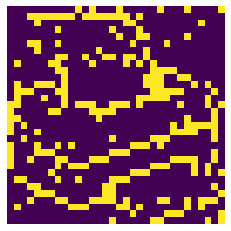

converged to this


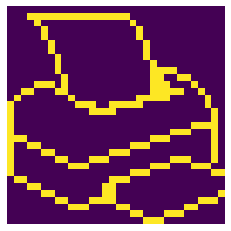

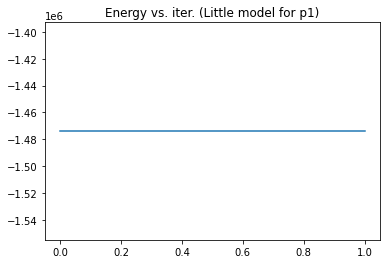

in 2 iterations p2 with 10.0% noise


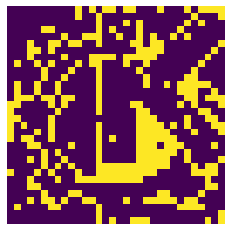

converged to this


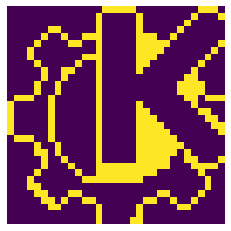

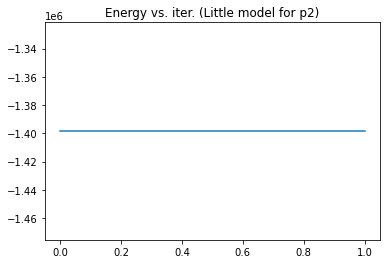

in 2 iterations p3 with 10.0% noise


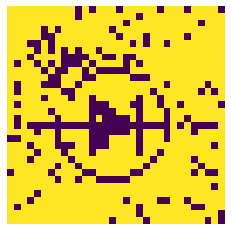

converged to this


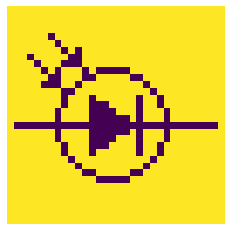

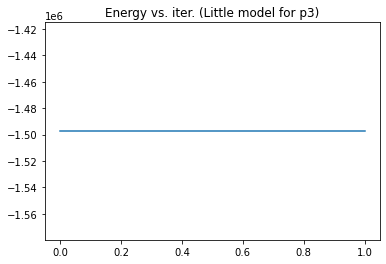

In [23]:
ratio = 0.1
#ratio = 0.4
#ratio = 0.5
#ratio = 0.6
#ratio = 0.8

hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True, norm=False)

for idx, pattern in enumerate(patterns):
    pattern_noisy = add_noise_via_flip(pattern, ratio)
    
    viz_recall_dict = {"i": 100, "shape": (32, 32)}
    patternr, it, energies = hn.recall_until_convergence(pattern_noisy, if_sequential=False, with_energy=True,
                                               exit=1000, **viz_recall_dict)
    print(f"in {it} iterations p{idx+1} with {ratio*100}% noise")
    plt.imshow(pattern_noisy.reshape(32,-1).T)
    plt.axis("off")
    plt.show()
    
    print("converged to this")
    
    plt.imshow(patternr.reshape(32,-1).T)
    plt.axis("off")
    plt.show()

    plt.plot(energies)
    plt.title(f"Energy vs. iter. (Little model for p{idx+1})")
    plt.show()

Up to 50 % of noise (randomly flip this many pixels) can be removed - noisy p1, p2, and p3 all converge to their own attractors, i.e.: themselves. 
At 50 %, noisy p1, p2, and p3 converges to p2, p1, and p1, respectively - incorrect attractors.
At 60%, noisy p1 and p2 converge to the inverse of their attractors, and noisy p3 converges to a spurious attractor.
Beyond around 70 %, they all converge to the inverse of their respective, correct attractors .

## Memory Capacity in Hopfield Networks

Let's add more memories / patterns to the network to see where the limit is. 

Firstly, let's add p4 into the weight matrix and check if moderately distorted patters can still be recognized.

In [24]:
patterns_all = read_pict_data(path_2_data)
n_patterns = 4
patterns = patterns_all[:n_patterns,:]
print(patterns.shape)

(4, 1024)


Try batch mode (Little model)

in 2 iterations this converged to


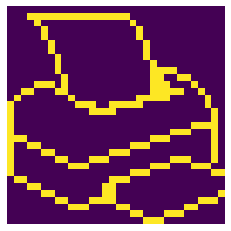

this


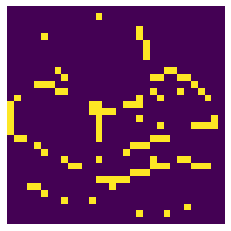

in 3 iterations this converged to


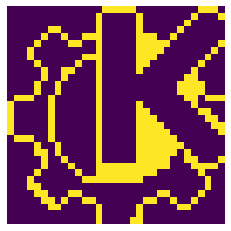

this


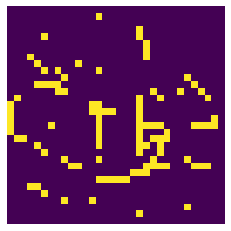

in 2 iterations this converged to


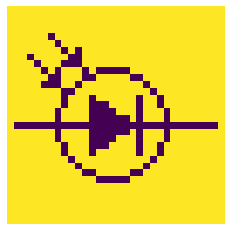

this


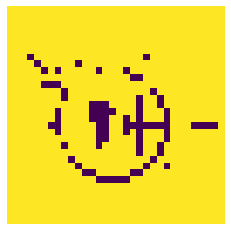

in 3 iterations this converged to


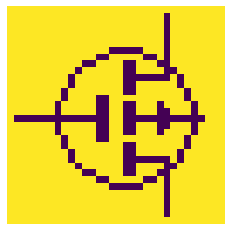

this


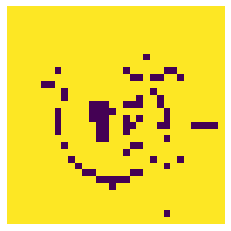

In [25]:
if_sequential = False
hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True, norm=False)

for pattern in patterns:
    patternr, it, _ = hn.recall_until_convergence(pattern, with_energy=False, 
                                                     if_sequential=if_sequential, 
                                                     exit=10000)
    print(f"in {it} iterations this converged to")
    plt.imshow(pattern.reshape(32,-1).T)
    plt.axis("off")
    plt.show()
    print(f"this")
    plt.imshow(patternr.reshape(32,-1).T)
    plt.axis("off")
    plt.show()

Try sequential mode.

in 10000 iterations this converged to


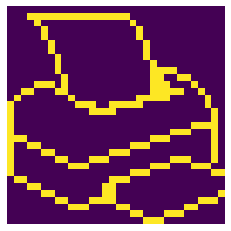

this


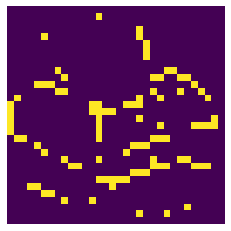

in 10000 iterations this converged to


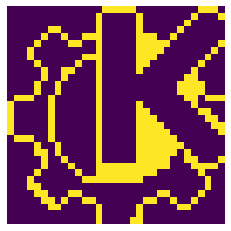

this


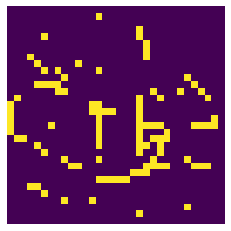

in 10000 iterations this converged to


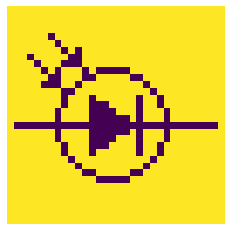

this


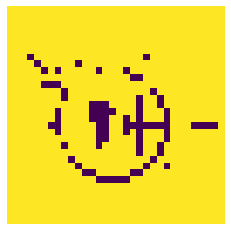

in 10000 iterations this converged to


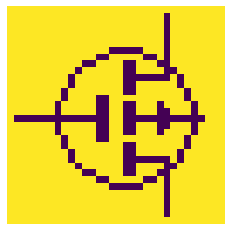

this


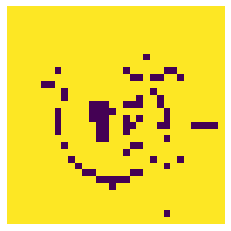

In [26]:
if_sequential = True
hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True, norm=False)

for pattern in patterns:
    patternr, it, _ = hn.recall_until_convergence(pattern, with_energy=False, 
                                                     if_sequential=if_sequential, 
                                                     exit=10000)
    print(f"in {it} iterations this converged to")
    plt.imshow(pattern.reshape(32,-1).T)
    plt.axis("off")
    plt.show()
    print(f"this")
    plt.imshow(patternr.reshape(32,-1).T)
    plt.axis("off")
    plt.show()

3 patterns could be stored so far with stable recall of all - stable points. Adding p4 and beyond worsens the network, and the patterns are not stable anymore.

Let's repeat this with learning a few random patterns instead of the pictures and let's see if the network can store more patterns - i.e.: have a greater memory.


Let's create 300 random patterns and train a 100-unit network with them. After each new pattern has been added to the weight matrix, the number of stable patterns (a single iteration does not cause them to change) is calculated and an accuracy score (representative of the memory capacity) is visualized.

In [27]:
def get_random_patterns(n, ndim, bias=0):
    """ Generates random patterns of dimension ndim, optionally biased random patterns with bias. 
    
    Parameters
    ----------
    n : int
        The number of pattern vectors.
    
    ndim : int
        The number of units of the pattern vector, i.e.: number of units in the Hopfield
        network trained on the patterns.
        
    bias : float
        For biasing the  random patterns.
    
    Returns
    ----------
    patterns : numpy.ndarray
        The patterns.
    """
    patterns = np.random.normal(loc=0, scale=1, size=(n, ndim)) + bias
    mask = patterns < 0
    patterns[mask] = -1.0
    patterns[np.invert(mask)] = 1.0
    return patterns

In [28]:
patterns_random = get_random_patterns(n=10, ndim=100)
patterns_random.shape

(10, 100)

Run the experiment with allowing for self-connections.

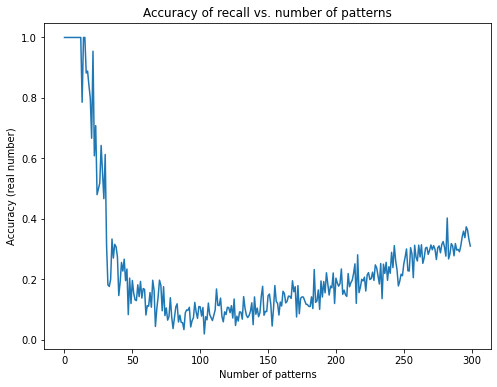

In [29]:
n_patterns = 300
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)
accuracies_all = []
print_me = False

for n_pattern in ns_patterns:
    
    patterns_random = get_random_patterns(n=n_pattern, ndim=ndim)
    hn = HopfieldNetwork()
    hn.init_weights(patterns_random, self_connections=True, norm=False)
    accuracies = []
    
    for pattern in patterns_random:
        
        patternr, it, energies = hn.recall_until_convergence(pattern, with_energy=False, if_sequential=False, 
                                                  exit=10000)
        accuracies.append(np.all(pattern == patternr))
    
    accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
    accuracies_all.append(accuracy)
    
    if print_me:
        print(f"n_pattern={n_pattern}, accuracy={accuracy}")

fig = plt.figure(figsize=(8,6))
plt.plot(accuracies_all)
plt.title("Accuracy of recall vs. number of patterns")
plt.ylabel("Accuracy (real number)")
plt.xlabel("Number of patterns")
plt.show()

The more patterns we train the network on (i.e.: save in the weight matrix), the lesser its memory capacity for a given number of neurons in the network.

It has been shown that the capacity of a Hopfield network is around 0.138N where N is the number of neurons in the network. In the case of the image data set before, the network could not live up to this standard. 

Nevertheless, in the case of random patterns here, the network memory capacity does show this tendency. For 100 units above, there is an abrupt drop in memory capacity at around 20 patterns in the plot, which is approximately 0.138x100 = 14

The difference between random patterns and the pictures is that the pictures are likely to be correlated, whereas the random patters are not. Training Hopfield networks on corralated data results in poor weights, with rather low memory (since recall is inaccurate with correlated weights). 

Let's do the same experiment, but with adding an increasing amount of noise to the patterns to be recalled.  

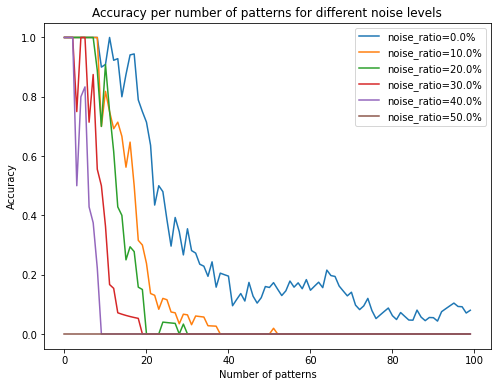

In [30]:
n_patterns = 100
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_noise_ratio = {}

noise_ratios = np.arange(0,6) / 10

print_me = False

for noise_ratio in noise_ratios:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns(n=n_pattern, ndim=ndim)
        hn = HopfieldNetwork()
        hn.init_weights(patterns_random, self_connections=True, norm=False)
        accuracies = []
        for pattern in patterns_random:
            pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern_noisy, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)
        
        if print_me:
            print(f"noise_ratio={noise_ratio}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_noise_ratio[str(noise_ratio)] = accuracies_all

fig = plt.figure(figsize=(8,6))
    
for noise_ratio, accuracies in accuracies_per_noise_ratio.items():
    plt.plot(accuracies, label=f"noise_ratio={float(noise_ratio)*100}%")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title('Accuracy per number of patterns for different noise levels')
plt.legend()
plt.show()

Increasing the noise in the patterns to be recalled also degrades the memory capacity of the Hopfield network.

The self-connections in the network are always positive and quite strong; they always support units to remain at their current state. In general it is a good idea to remove self-connections, even though it seems that this step lowers the memory performance. In fact, self-connections promote the formation of spurious patterns and have negative effect on noise removal capabilities. So let's check the same experiment with the self-connections removed this time.

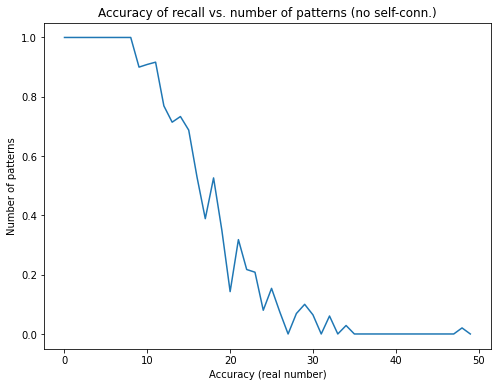

In [31]:
# This cell takes around 3-4 mins to run on Intel i7 CPU

self_connections = False
n_patterns = 50
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)
accuracies_all = []
print_me = False

for n_pattern in ns_patterns:
    
    patterns_random = get_random_patterns(n=n_pattern, ndim=ndim)
    hn = HopfieldNetwork()
    hn.init_weights(patterns_random, self_connections=self_connections, norm=False)
    accuracies = []
    
    for pattern in patterns_random:
        
        patternr, it, energies = hn.recall_until_convergence(pattern, with_energy=False, if_sequential=False, 
                                                  exit=10000)
        accuracies.append(np.all(pattern == patternr))
    
    accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
    accuracies_all.append(accuracy)
    
    if print_me:
        print(f"n_pattern={n_pattern}, accuracy={accuracy}")

fig = plt.figure(figsize=(8,6))
plt.plot(accuracies_all)
plt.title("Accuracy of recall vs. number of patterns (no self-conn.)")
plt.xlabel("Accuracy (real number)")
plt.ylabel("Number of patterns")
plt.show()

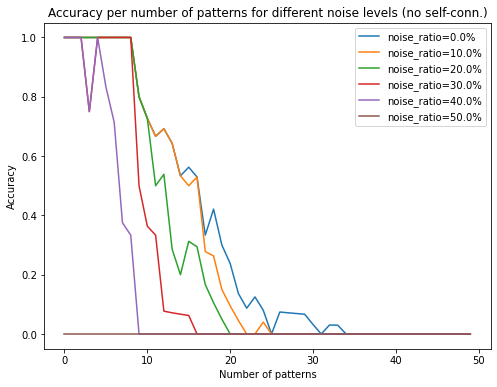

In [32]:
# This cell takes around 3-4 mins to run on Intel i7 CPU

self_connections = False
n_patterns = 50
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_noise_ratio = {}

noise_ratios = np.arange(0,6) / 10

print_me = False

for noise_ratio in noise_ratios:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns(n=n_pattern, ndim=ndim)
        hn = HopfieldNetwork()
        hn.init_weights(patterns_random, self_connections=self_connections, norm=False)
        accuracies = []
        for pattern in patterns_random:
            pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern_noisy, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)
        
        if print_me:
            print(f"noise_ratio={noise_ratio}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_noise_ratio[str(noise_ratio)] = accuracies_all
    
fig = plt.figure(figsize=(8,6))
    
for noise_ratio, accuracies in accuracies_per_noise_ratio.items():
    plt.plot(accuracies, label=f"noise_ratio={float(noise_ratio)*100}%")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title('Accuracy per number of patterns for different noise levels (no self-conn.)')
plt.legend()
plt.show()

Indeed, removing the self-connections, further degrades the memory of the network, but results in fewer spurious attractors.

Now, let's bias the patterns, and see the same experiment when the patterns contain more +1.

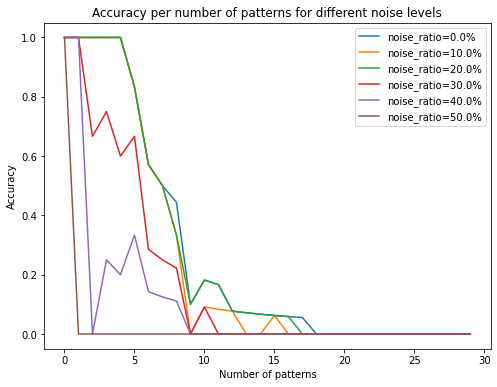

In [33]:
bias = 0.5
n_patterns = 30
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)
print_me = False

accuracies_per_noise_ratio = {}

noise_ratios = np.arange(0,6) / 10

for noise_ratio in noise_ratios:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns(n=n_pattern, ndim=ndim, bias=bias)
        hn = HopfieldNetwork()
        hn.init_weights(patterns_random, self_connections=True, norm=False)
        accuracies = []
        for pattern in patterns_random:
            pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern_noisy, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)
        
        if print_me:
            print(f"noise_ratio={noise_ratio}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_noise_ratio[str(noise_ratio)] = accuracies_all

fig = plt.figure(figsize=(8,6))
    
for noise_ratio, accuracies in accuracies_per_noise_ratio.items():
    plt.plot(accuracies, label=f"noise_ratio={float(noise_ratio)*100}%")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title('Accuracy per number of patterns for different noise levels')
plt.legend()
plt.show()

Biased patterns further degrade the memory capacity of the Hopfield network since the recall update rule cannot account for the sparse patterns without a bias term in the update rule.

## 3.6 Sparse Patterns

The reduction in capacity because of bias is troublesome, since real data usually is not evenly balanced. Here the network is trained on sparse patterns but this time the weights are centered (i.e.: the mean activity in the patterns is removed from the weights) and a slightly modified update rule is used to account for the bias in the data.

In [34]:
def get_random_patterns_sparse(n, ndim, activity=0.7):
    """ Generates random patterns of dimension ndim, optionally biased random patterns with bias. 
    
    Parameters
    ----------
    n : int
        The number of pattern vectors.
    
    ndim : int
        The number of units of the pattern vector, i.e.: number of units in the Hopfield
        network trained on the patterns.
        
    activity : float
        Defines the mean activity in the patterns (the lower, the sparser).
    
    Returns
    ----------
    patterns : numpy.ndarray
        The patterns.
    """
    patterns = np.zeros((n, ndim))
    n_active = int(activity * patterns.shape[1])
    
    for pattern in patterns:
        indices = np.arange(pattern.shape[0])
        mask = np.random.choice(indices, n_active, replace=False)
        pattern[mask] = 1.0
    
    average_activity = np.sum(patterns) * (patterns.shape[1] * patterns.shape[0])**(-1)
    
    return patterns

In [35]:
# Testing
n_pattern = 3
ndim = 100
activity=0.1

patterns_random_sparse = get_random_patterns_sparse(n=n_pattern, ndim=ndim, activity=activity)
average_activity = \
    np.sum(patterns_random_sparse) * \
    (patterns_random_sparse.shape[1] * \
     patterns_random_sparse.shape[0])**(-1)
print(f"mean activity level: {average_activity * 100:.2f}%")
print(patterns_random_sparse)

mean activity level: 10.00%
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 0.]]


Let's test if a stable point can be recalled with the sparse/biased recall update rule, and no self-connections.

[[ 0.    0.03  0.03 ... -0.07 -0.07  0.03]
 [ 0.03  0.    0.03 ... -0.07 -0.07  0.03]
 [ 0.03  0.03  0.   ... -0.07 -0.07  0.03]
 ...
 [-0.07 -0.07 -0.07 ...  0.    0.83 -0.07]
 [-0.07 -0.07 -0.07 ...  0.83  0.   -0.07]
 [ 0.03  0.03  0.03 ... -0.07 -0.07  0.  ]]
True


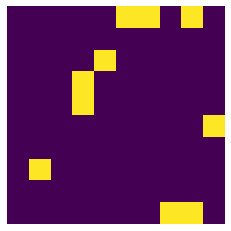

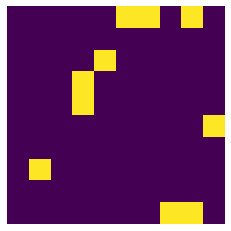

In [36]:
# Testing

idx = 1
sparse = True
bias = 2
hn = HopfieldNetwork(sparse=sparse)
hn.init_weights(patterns_random_sparse, self_connections=False, norm=False, bias=bias)
print(hn.weights)
patternr, it, energies = hn.recall_until_convergence(patterns_random_sparse[idx], 
                                                     with_energy=False, if_sequential=False, 
                                                     exit=10000)
print(np.all(patternr == patterns_random_sparse[idx]))

plt.imshow(patterns_random_sparse[idx].reshape(10,10))
plt.axis("off")
plt.show()

plt.imshow(patternr.reshape(10,10))
plt.axis("off")
plt.show()

Similar experiment as before, but this time the memory capacity vs. number of patterns is investigated for different values of network bias in the recall update rule. 

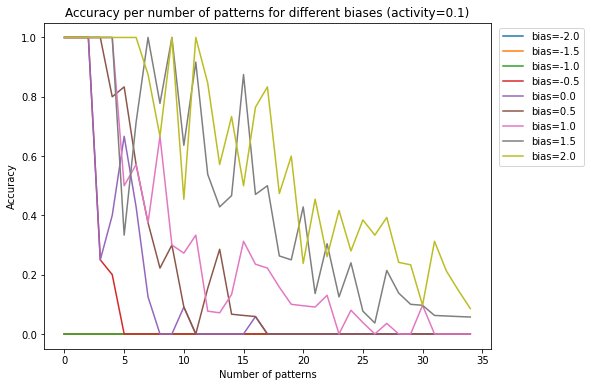

In [37]:
n_patterns = 35
ndim = 100
activity = 0.1
sparse = True
print_me = False

ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_biases = {}

biases = np.arange(-20,22,5) / 10

for bias in biases:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns_sparse(n=n_pattern, ndim=ndim, activity=activity)
        hn = HopfieldNetwork(sparse=sparse)
        hn.init_weights(patterns_random, self_connections=True, norm=False, bias=bias)
        accuracies = []
        for pattern in patterns_random:
            #pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)
        
        if print_me:
            print(f"bias={bias}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_biases[str(bias)] = accuracies_all
    
fig = plt.figure(figsize=(8,6))
    
for bias, accuracies in accuracies_per_biases.items():
    plt.plot(accuracies, label=f"bias={bias}")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per number of patterns for different biases (activity={activity})')
plt.legend(bbox_to_anchor=(1.22, 1), loc="upper right")
plt.show()

So in the case of sparse patterns, the network memory capacity is better when the modified update rule that accounts for the bias is used and when the weights are centered according to the mean activity in the sparse patterns.

In the case of an average of 10% activity in the patterns, the more positive of the bias among the values test (e.g.: bias = 2), the greater the memory capacity of the network. Nevertheless, negative biases in this case, almost fully eliminate the memory of the network. 

Let's further decrease the activity and run the same experiment.

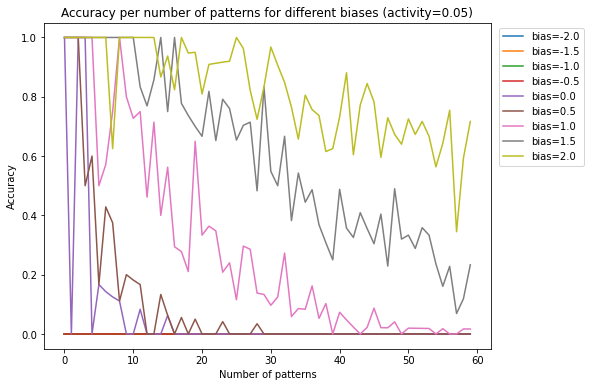

In [38]:
n_patterns = 60
ndim = 100
activity = 0.05
sparse = True

ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_biases = {}

biases = np.arange(-20,22,5) / 10

print_me = False

for bias in biases:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns_sparse(n=n_pattern, ndim=ndim, activity=activity)
        hn = HopfieldNetwork(sparse=sparse)
        hn.init_weights(patterns_random, self_connections=True, norm=False, bias=bias)
        accuracies = []
        for pattern in patterns_random:
            #pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)
        
        if print_me:
            print(f"bias={bias}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_biases[str(bias)] = accuracies_all
    
fig = plt.figure(figsize=(8,6))
    
for bias, accuracies in accuracies_per_biases.items():
    plt.plot(accuracies, label=f"bias={bias}")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per number of patterns for different biases (activity={activity})')
plt.legend(bbox_to_anchor=(1.22, 1), loc="upper right")
plt.show()

It seems that the memory is even further expanded for the same bias values.

Lastly, for an activity level of 1%, we get something unexplainably weird - the more patterns are stored, the greater the memory. This is most certainly untrue, so I guess this is the limit of my from-scratch implementation ...

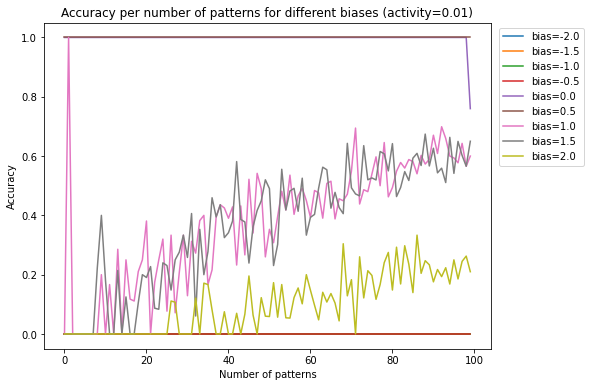

In [39]:
n_patterns = 100
ndim = 100
activity = 0.01
sparse = True

ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_biases = {}

biases = np.arange(-20,22,5) / 10

print_me = False

for bias in biases:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns_sparse(n=n_pattern, ndim=ndim, activity=activity)
        hn = HopfieldNetwork(sparse=sparse)
        hn.init_weights(patterns_random, self_connections=True, norm=False, bias=bias)
        accuracies = []
        for pattern in patterns_random:
            #pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)
        
        if print_me:
            print(f"bias={bias}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_biases[str(bias)] = accuracies_all
    
fig = plt.figure(figsize=(8,6))
    
for bias, accuracies in accuracies_per_biases.items():
    plt.plot(accuracies, label=f"bias={bias}")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per number of patterns for different biases (activity={activity})')
plt.legend(bbox_to_anchor=(1.22, 1), loc="upper right")
plt.show()